In [1]:
import pandas as pd

import tensorflow as tf
import import_ipynb
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras import layers

from keras.layers import Input, Add, Dense,GlobalAvgPool2D, Concatenate, AvgPool2D, Dropout, ReLU, Activation, MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
import cv2
import os 
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import imshow
%matplotlib inline

from keras import backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\hira\AppData\Roaming\Python\Python39\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [2]:
data=pd.read_csv('CheXpert-v1.0-small/train.csv')
data = data[data['Frontal/Lateral'] == 'Frontal']
train=data.drop(['Sex','Age','Frontal/Lateral','AP/PA','No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation',
              'Atelectasis', 'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices'],axis=1)


In [3]:
print (train)

                                                     Path  Pneumonia
0       CheXpert-v1.0-small/train/patient00001/study1/...        NaN
1       CheXpert-v1.0-small/train/patient00002/study2/...        NaN
2       CheXpert-v1.0-small/train/patient00002/study1/...        NaN
4       CheXpert-v1.0-small/train/patient00003/study1/...        NaN
5       CheXpert-v1.0-small/train/patient00004/study1/...        NaN
...                                                   ...        ...
223409  CheXpert-v1.0-small/train/patient64537/study2/...        NaN
223410  CheXpert-v1.0-small/train/patient64537/study1/...        0.0
223411  CheXpert-v1.0-small/train/patient64538/study1/...        NaN
223412  CheXpert-v1.0-small/train/patient64539/study1/...       -1.0
223413  CheXpert-v1.0-small/train/patient64540/study1/...        NaN

[191027 rows x 2 columns]


In [4]:
train=train.dropna()
train =train.replace(-1,1)

In [5]:
train=train.head(1000)

In [6]:
valids= pd.read_csv('CheXpert-v1.0-small/valid.csv')
valids = valids[valids['Frontal/Lateral'] == 'Frontal']
valids=valids.drop(['Sex','Age','Frontal/Lateral','AP/PA','No Finding','Enlarged Cardiomediastinum','Cardiomegaly','Lung Opacity','Lung Lesion','Edema','Consolidation',
              'Atelectasis', 'Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices'],axis=1)
print(valids)

                                                  Path  Pneumonia
0    CheXpert-v1.0-small/valid/patient64541/study1/...        0.0
1    CheXpert-v1.0-small/valid/patient64542/study1/...        0.0
3    CheXpert-v1.0-small/valid/patient64543/study1/...        0.0
4    CheXpert-v1.0-small/valid/patient64544/study1/...        0.0
5    CheXpert-v1.0-small/valid/patient64545/study1/...        0.0
..                                                 ...        ...
229  CheXpert-v1.0-small/valid/patient64736/study1/...        0.0
230  CheXpert-v1.0-small/valid/patient64737/study1/...        0.0
231  CheXpert-v1.0-small/valid/patient64738/study1/...        0.0
232  CheXpert-v1.0-small/valid/patient64739/study1/...        0.0
233  CheXpert-v1.0-small/valid/patient64740/study1/...        0.0

[202 rows x 2 columns]


In [7]:
train_d = ImageDataGenerator(rescale= 1./255)
validation_d = ImageDataGenerator(rescale= 1./255)

In [8]:
train_datagen = train_d.flow_from_dataframe(dataframe=train,
                                            #directory="CheXpert-v1.0-small",
                                            x_col="Path",
                                            y_col=['Pneumonia'],
                                            class_mode = "raw",
                                            color_mode='rgb',
                                            target_size=(224,224),
                                            batch_size=32)
validation_datagen = validation_d.flow_from_dataframe(dataframe=valids,
                                            #directory="CheXpert-v1.0-small",
                                            x_col="Path",
                                            y_col=['Pneumonia'],
                                            class_mode = "raw",
                                            color_mode='rgb',
                                            target_size=(224,224),
                                            batch_size=32)

Found 1000 validated image filenames.
Found 202 validated image filenames.


In [9]:
model_d= tf.keras.applications.densenet.DenseNet121()

In [10]:
# Replace the output layer with a single node and sigmoid activation function
x = model_d.layers[-3].output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x) 
x = Dense(512, activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=model_d.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
for layer in model.layers[:-9]:
    layer.trainable= False

In [12]:
model.compile(optimizer= Adam(lr= 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

 dense (Dense)                  (None, 1024)         1049600     ['dropout[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 512)          524800      ['dense[0][0]']                  
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 512)         2048        ['dense_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dropout_1 (Dropout)            (None, 512)          0           ['batch_normalization_1[0][0]']  
                                                                                                  
 dense_2 (Dense)                (None, 2)            1026        ['dropout_1[0][0]']              
          

In [14]:
!pip install pydot
!pip install graphviz
!pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.681184 to fit



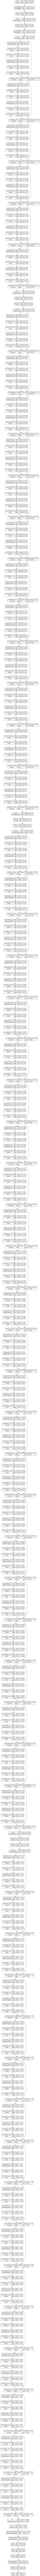

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit_generator(
   train_datagen,
    steps_per_epoch=20,
    epochs=10,
    validation_data=validation_datagen,
    validation_steps=3
)